In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as f
import torch.optim as optim
from torchvision import transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader,Dataset
import os
from PIL import Image

In [2]:
class mydata(Dataset):
    def __init__(self,image_folder,transform=None):
        self.image_folder = image_folder
        self.transform = transform
        self.image_file = [file for file in os.listdir(image_folder) if file.endswith('.png')]
    
    def __len__(self):
        return len(self.image_file)
    
    def __getitem__(self,idx):
        img_name =  os.path.join(self.image_folder,self.image_file[idx])
        
        label = int(self.image_file[idx].split('_')[0])
        image = Image.open(img_name)
        if self.transform:
            image = self.transform(image)
            
        return image,label
    
    
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5),(0.5))
])

train_path = '/home/manchik-pt7714/Documents/PT2/MNIST(LDS)/train_images'
test_path = '/home/manchik-pt7714/Documents/PT2/MNIST(LDS)/test_image'
validate_path = '/home/manchik-pt7714/Documents/PT2/MNIST(LDS)/validate_image'


train_data = mydata(image_folder=train_path,transform=transform)
test_data = mydata(image_folder=test_path,transform=transform)
validate_data = mydata(image_folder=validate_path,transform = transform)


train_load = DataLoader(train_data,batch_size=128,shuffle=True)
test_load = DataLoader(test_data,batch_size=128,shuffle=False)
validate_load = DataLoader(validate_data,batch_size=128,shuffle= False)



In [3]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.conv1 = nn.Conv2d(1,3,kernel_size = 5)
        self.conv2 = nn.Conv2d(3,20,kernel_size = 5)
        self.pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(20*4*4,150)
        self.fc2 = nn.Linear(150,10)
        self.dropout = nn.Dropout(0.5) 
        
    def forward(self,x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1,20*4*4)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return f.softmax(x,dim=1)
    
model = CNN()

In [4]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.001)

In [5]:
epochs = 10
training_losses = []
validation_losses = []

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for images,labels in train_load:
        output = model(images)
        loss = criterion(output,labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
    training_losses.append(train_loss/len(train_load))
                           
    model.eval()
    validation_loss = 0.0
    with torch.no_grad():
        for images,labels in validate_load:
            output = model(images)
            loss = criterion(output,labels)
            validation_loss += loss.item()
                           
    validation_losses.append(validation_loss/len(validate_load))
                             
    print(f"Epoch:{epoch+1}/{epochs} , Training_loss {training_losses[-1]:.4f} , Validation_loss {validation_losses[-1]:.4f}")

Epoch:1/10 , Training_loss 1.6782 , Validation_loss 1.5175
Epoch:2/10 , Training_loss 1.5235 , Validation_loss 1.4955
Epoch:3/10 , Training_loss 1.5056 , Validation_loss 1.4886
Epoch:4/10 , Training_loss 1.5000 , Validation_loss 1.4842
Epoch:5/10 , Training_loss 1.4955 , Validation_loss 1.4824
Epoch:6/10 , Training_loss 1.4916 , Validation_loss 1.4809
Epoch:7/10 , Training_loss 1.4881 , Validation_loss 1.4784
Epoch:8/10 , Training_loss 1.4859 , Validation_loss 1.4770
Epoch:9/10 , Training_loss 1.4853 , Validation_loss 1.4762
Epoch:10/10 , Training_loss 1.4839 , Validation_loss 1.4765


In [6]:
def evaluate_accuracy(loader,model):
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images,labels in loader:
            output = model(images)
            _, predicted = torch.max(output,1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            
    accuracy = 100 * correct/total
    return accuracy
    
test_accuracy = evaluate_accuracy(test_load,model)
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 98.40%


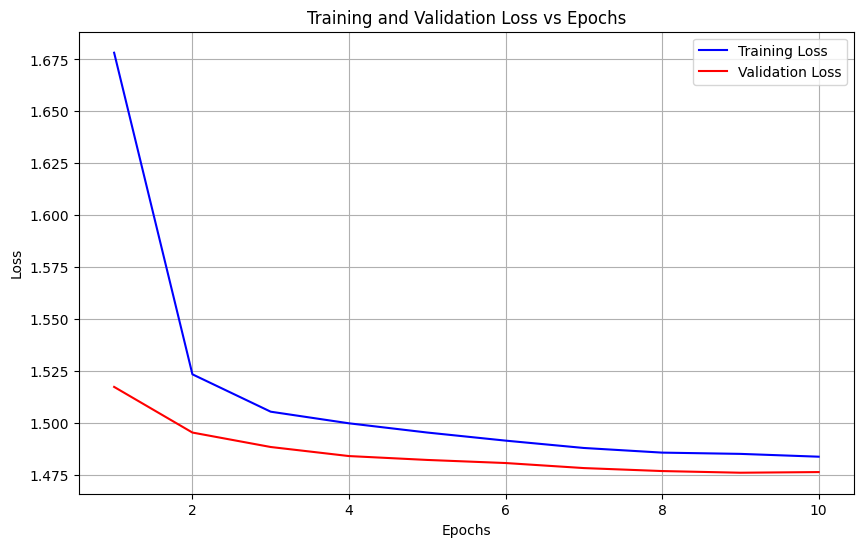

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), training_losses, label='Training Loss', color='blue')
plt.plot(range(1, epochs + 1), validation_losses, label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss vs Epochs')
plt.legend()
plt.grid(True)
plt.show()